In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
import statistics
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
from layers import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from models import LSTMEmbedding, LSTMVAEEmbedding #,MLPEmbedding, ETDEmbedding, AMIEmbedding, TICAEmbedding
from regularizers import FNN
import seaborn as sns
sns.set_style("white")

In [3]:
def lorenz(x, t, robustness_to_scale=1):
    return [
        robustness_to_scale*10 * (x[1] - x[0]/robustness_to_scale),
        x[0]/robustness_to_scale * (28 - x[2]) - x[1],
        x[0]/robustness_to_scale * x[1] - 8 / 3 * x[2],
    ]

In [13]:
# Numerical integrating a trajectory
# Choice of dt to ba a fractional value of the value found using the mutual information criterion

dt = 0.004
num_steps =500
t_train = np.arange(0, num_steps, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_dot_train_measured = np.array(
    [lorenz(x_train[i], 0) for i in range(t_train.size)]
)

adjustement=10
dt_adjusted=dt*adjustement
obs = x_train[::adjustement,:]
obs_x = obs[:,0]
obs_y = obs[:,1]
obs_z = obs[:,2]

In [78]:
# creating Takens embedding
delay=1

takens = np.concatenate(([obs_x[:-2*delay]], [obs_x[2*delay:]], [obs_x[delay:-delay]]), axis=0).T

In [79]:
takens.shape

(12492, 3)

In [86]:
target= np.array([obs_x ,obs_y, obs_z]).T
target[:-2*delay].shape

(12492, 3)

In [83]:
np.array([obs_x ,obs_y, obs_z]).T

array([[-8.        ,  8.        , 27.        ],
       [-2.88204816,  7.07817157, 22.76571056],
       [ 0.28427098,  6.52411114, 20.16363077],
       ...,
       [ 2.21183599,  3.15104903, 16.16077835],
       [ 2.7015207 ,  4.22648232, 14.86743735],
       [ 3.44990792,  5.69594034, 13.93943002]])

0.6306776861103804
[[ 1.00000000e+00 -5.19189290e-17 -2.56083833e-16]
 [ 6.03697277e-01 -3.40473651e-02  5.67290483e-01]
 [ 7.01299770e-03  8.74648841e-03 -3.06782310e-03]]


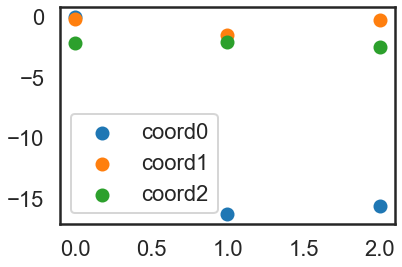

In [94]:
takens = np.concatenate(([obs_x[:-4*delay]], [obs_x[4*delay:]], [obs_x[delay:-3*delay]]), axis=0).T
#%% Linearly decode embeddings into original space
reg = linear_model.LinearRegression()
# reg.fit(coords_lstm, obs[10:])
target= np.array([obs_x ,obs_y, obs_z]).T
reg.fit(takens, target[:-4*delay])
x_pred = reg.predict(takens)

print(reg.score(takens, target[:-4*delay]))
print(reg.coef_)
plt.figure()
plt.scatter(range(len(reg.coef_[0])), np.log10(np.abs(reg.coef_[0])), label='coord0')
plt.scatter(range(len(reg.coef_[0])), np.log10(np.abs(reg.coef_[1])), label='coord1')
plt.scatter(range(len(reg.coef_[0])), np.log10(np.abs(reg.coef_[2])), label='coord2')
plt.legend()

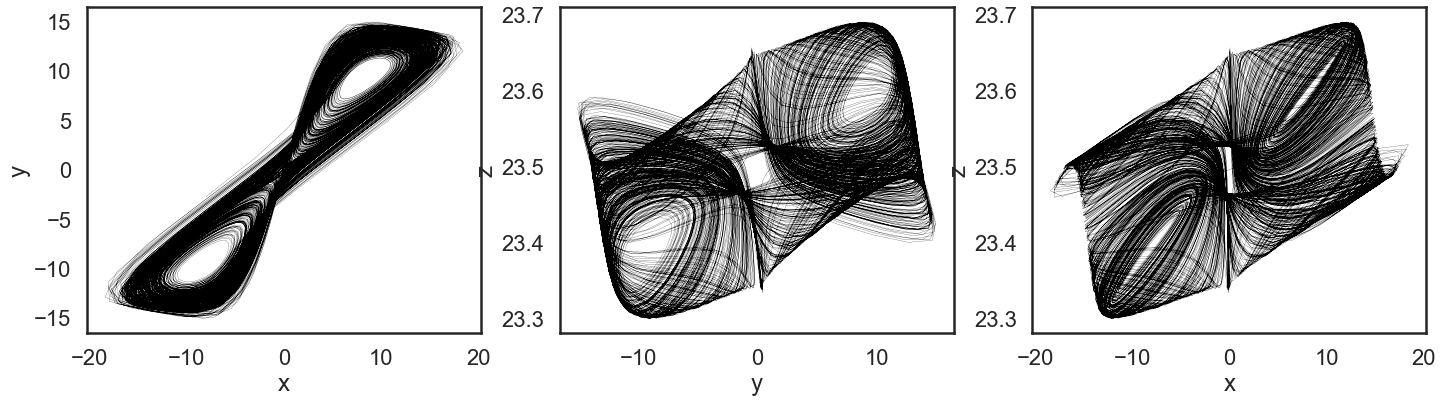

In [95]:
# reconstruction
sns.set_context("poster")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].plot(x_pred[:,0], x_pred[:,1], 'k', linewidth=.2)
ax[1].set_xlabel('y')
ax[1].set_ylabel('z')
ax[1].plot(x_pred[:,1], x_pred[:,2], 'k', linewidth=.2)
ax[2].set_xlabel('x')
ax[2].set_ylabel('z')
ax[2].plot(x_pred[:,0], x_pred[:,2], 'k', linewidth=.2)

In [52]:
%%time
# LSTM
# use beta =0.01
tf.keras.backend.clear_session()
n_latent =6
# define prior distribution for the code, which is an isotropic Gaussian
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(n_latent), scale=1.), 
                        reinterpreted_batch_ndims=1)
lstm_model = LSTMVAEEmbedding(n_latent, 
                     time_window=10, 
                     tau=0,
                     random_state=0,
                     latent_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=0.1)
                     )
train_steps= 200
coords_lstm = lstm_model.fit_transform(obs_x, train_steps=train_steps, verbose = 1)
print("LSTM complete")

Epoch 1/200
125/125 [==============================] - 14s 26ms/step - loss: 1.0996
Epoch 2/200
125/125 [==============================] - 3s 22ms/step - loss: 0.8330
Epoch 3/200
125/125 [==============================] - 3s 23ms/step - loss: 0.6897
Epoch 4/200
125/125 [==============================] - 3s 27ms/step - loss: 0.6430
Epoch 5/200
125/125 [==============================] - 3s 22ms/step - loss: 0.6162
Epoch 6/200
125/125 [==============================] - 3s 22ms/step - loss: 0.5934
Epoch 7/200
125/125 [==============================] - 3s 21ms/step - loss: 0.5824
Epoch 8/200
125/125 [==============================] - 3s 22ms/step - loss: 0.5736
Epoch 9/200
125/125 [==============================] - 3s 22ms/step - loss: 0.5684
Epoch 10/200
125/125 [==============================] - 3s 24ms/step - loss: 0.5662
Epoch 11/200
125/125 [==============================] - 3s 24ms/step - loss: 0.5610
Epoch 12/200
125/125 [==============================] - 3s 25ms/step - loss: 0.5577


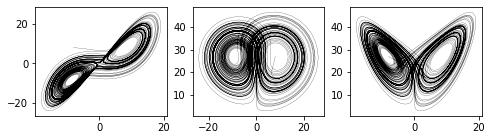

In [104]:
# %% Plots of original space
# plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,2))
ax[0].plot(obs_x, obs_y, 'k', linewidth=.2)
ax[1].plot(obs_y, obs_z, 'k', linewidth=.2)
ax[2].plot(obs_x, obs_z, 'k', linewidth=.2)

0.181471812196585
[[-7.84504786e-02 -1.30632490e-01 -1.48175642e-01 -1.39504885e-02
   6.76720366e-02 -5.13915396e+00]
 [-9.21165571e-02 -1.25586554e-01 -1.61316723e-01 -1.07593304e-02
   8.04936811e-02 -3.31489325e+00]
 [ 1.56852841e-01  1.62616149e-01  3.17881219e-02  8.36486965e-02
  -6.86060521e-04 -7.01241493e-02]]


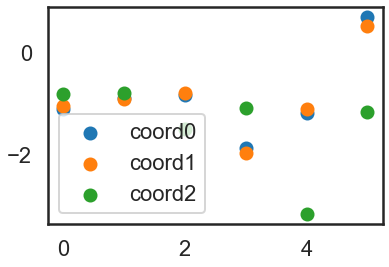

In [57]:
#%% Linearly decode embeddings into original space
reg = linear_model.LinearRegression()
# reg.fit(coords_lstm, obs[10:])
target= np.array([obs_x ,obs_y, obs_z]).T
reg.fit(coords_lstm, target[10:])
x_pred = reg.predict(coords_lstm)

print(reg.score(coords_lstm, target[10:]))
print(reg.coef_)
plt.figure()
plt.scatter(range(len(reg.coef_[0])), np.log10(np.abs(reg.coef_[0])), label='coord0')
plt.scatter(range(len(reg.coef_[0])), np.log10(np.abs(reg.coef_[1])), label='coord1')
plt.scatter(range(len(reg.coef_[0])), np.log10(np.abs(reg.coef_[2])), label='coord2')
plt.legend()

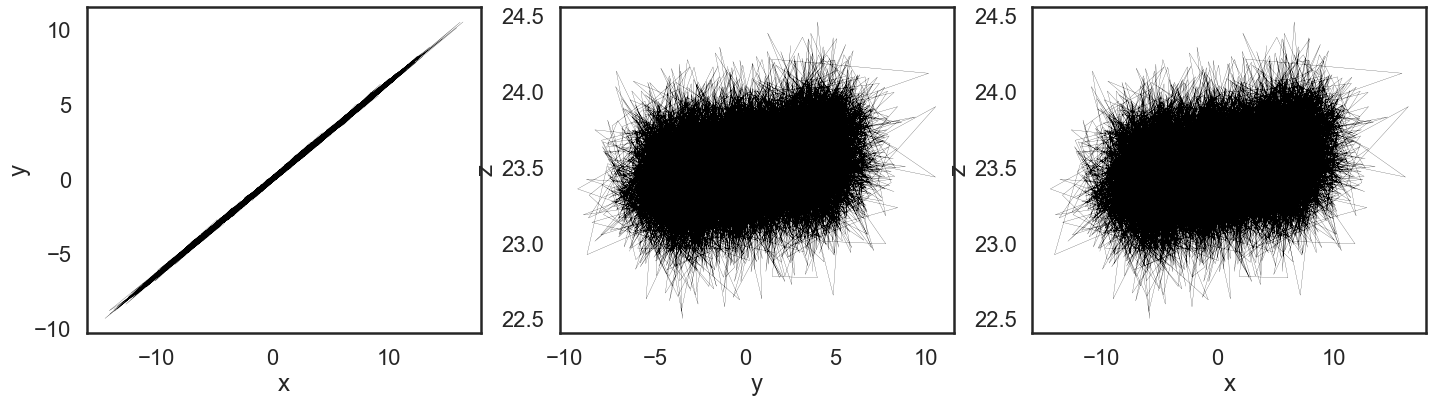

In [58]:
# reconstruction
sns.set_context("poster")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].plot(x_pred[:,0], x_pred[:,1], 'k', linewidth=.2)
ax[1].set_xlabel('y')
ax[1].set_ylabel('z')
ax[1].plot(x_pred[:,1], x_pred[:,2], 'k', linewidth=.2)
ax[2].set_xlabel('x')
ax[2].set_ylabel('z')
ax[2].plot(x_pred[:,0], x_pred[:,2], 'k', linewidth=.2)

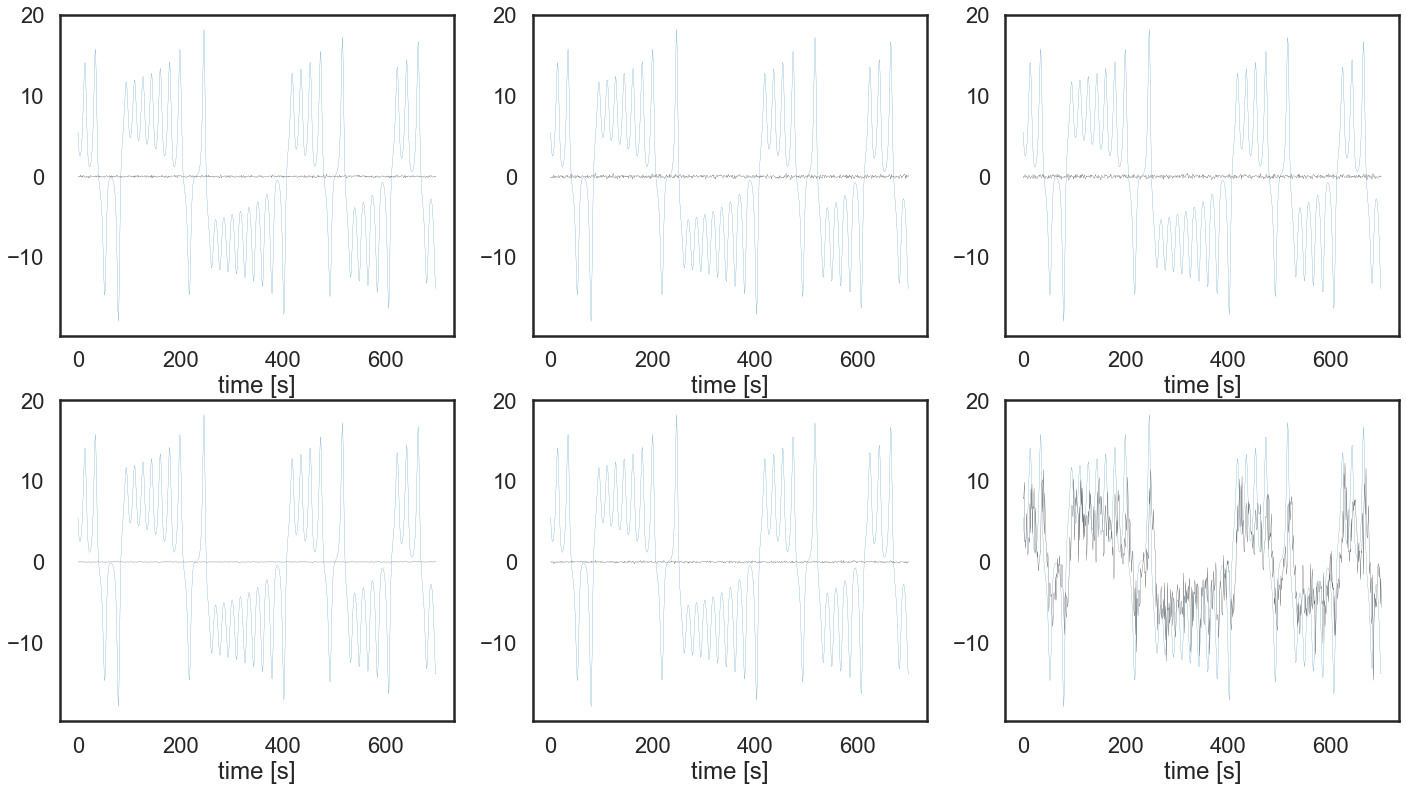

In [59]:
# Decomposing x
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24,13))
for i, coef in enumerate(reg.coef_[0]):
#     print(i%3, int(i/4))
    ax[int(i/3), i%3].plot((coef* coords_lstm[:,i])[100:800], 'k', linewidth=.2)
    ax[int(i/3), i%3].plot((obs_x )[10:][100:800],  linewidth=.2)
    ax[int(i/3), i%3].set_xlabel('time [s]')

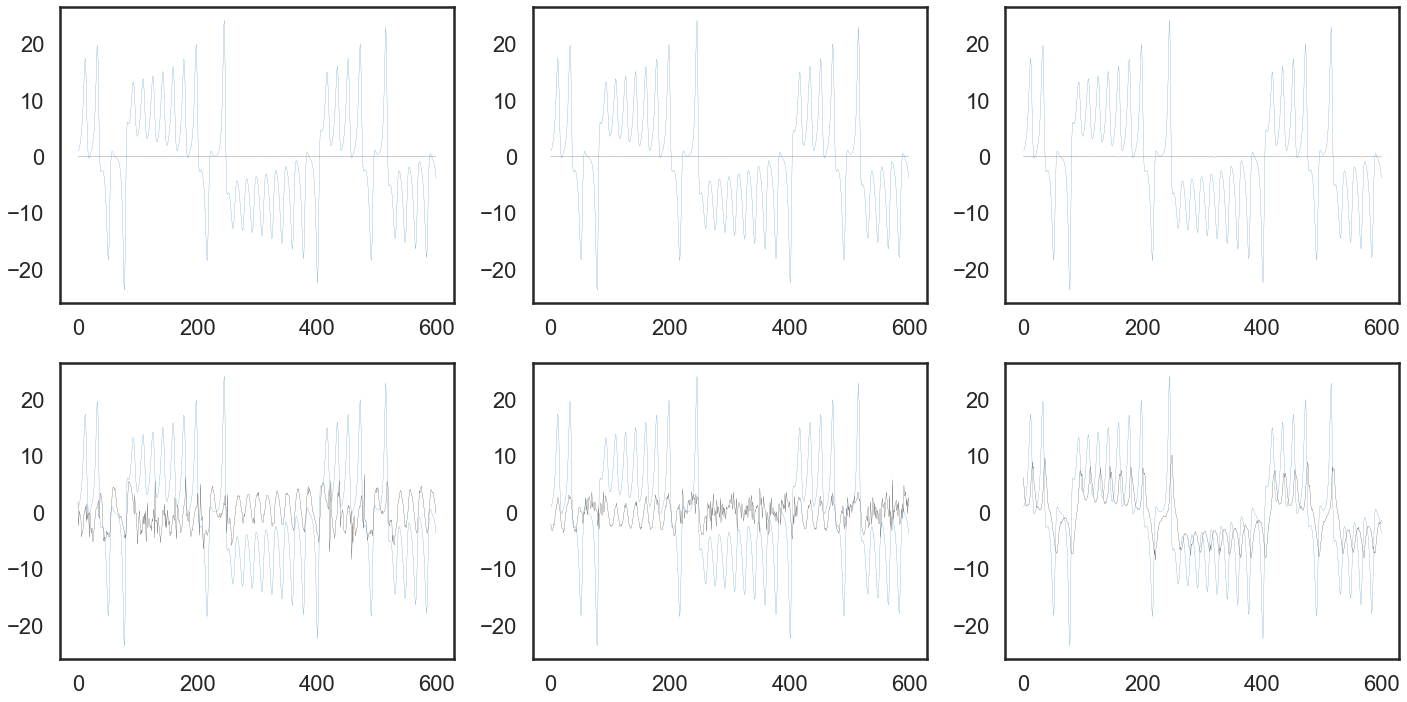

In [36]:
# Decomposing y
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24,12))
for i, coef in enumerate(reg.coef_[1]):
#     print(i%3, int(i/4))
    ax[int(i/3), i%3].plot((coef* coords_lstm[:,i])[100:700], 'k', linewidth=.2)
    ax[int(i/3), i%3].plot((obs_y[10:])[100:700],  linewidth=.2)

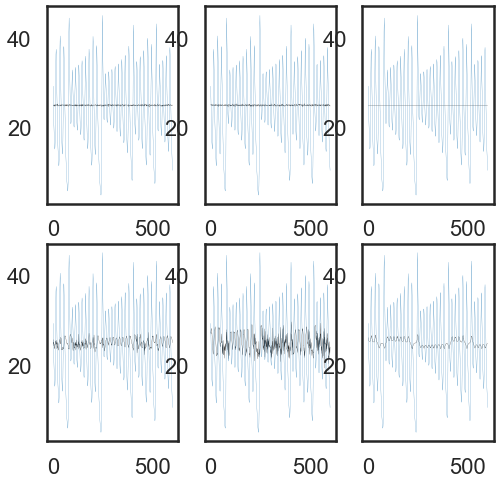

In [37]:
# Decomposing z
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8,8))
for i, coef in enumerate(reg.coef_[2]):
#     print(i%3, int(i/4))
    ax[int(i/3), i%3].plot((coef* coords_lstm[:,i])[100:700] +25, 'k', linewidth=.2)
    ax[int(i/3), i%3].plot((obs[10:,2])[100:700],  linewidth=.2)

LSTM complete
LSTM complete
LSTM complete
LSTM complete
LSTM complete
LSTM complete


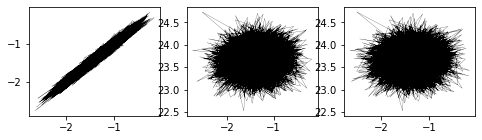

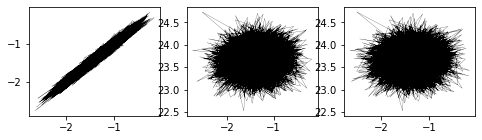

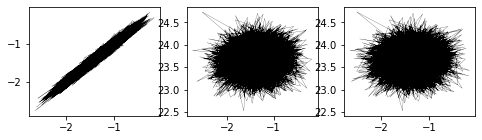

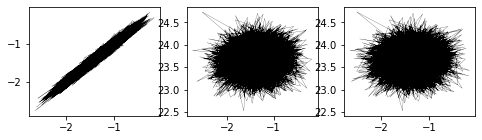

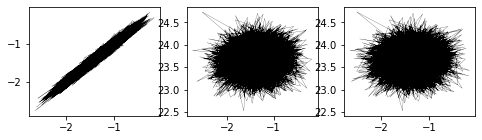

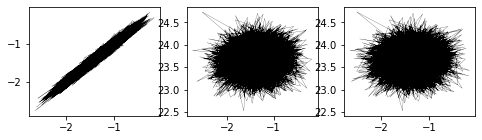

In [109]:
# Dimensionality

lambda_list= np.geomspace(0.01, 10,num=6)
for strength in lambda_list:
    # LSTM
    tf.keras.backend.clear_session()
    lstm_model = LSTMVAEEmbedding(n_latent, 
                     time_window=10, 
                     tau=0,
                     random_state=0,
                     latent_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=3)
                     )
    coords_lstm = lstm_model.fit_transform(obs_x,verbose =0)
    print("LSTM complete")

    # reconstruction
    reg = linear_model.LinearRegression()
    target= np.array([obs_x ,obs_y, obs_z]).T
    reg.fit(coords_lstm, target[10:])
    x_pred = reg.predict(coords_lstm)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,2))
    ax[0].plot(x_pred[:,0], x_pred[:,1], 'k', linewidth=.2)
    ax[1].plot(x_pred[:,1], x_pred[:,2], 'k', linewidth=.2)
    ax[2].plot(x_pred[:,0], x_pred[:,2], 'k', linewidth=.2)